# 2. Classify images with Xception

Trained on CelebA [dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

In [1]:
import os

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.applications import Xception
from keras import layers
from keras.applications.xception import preprocess_input

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


## Xception training and testing

CelebA dataset has to be downloaded manualy from [google drive](https://drive.google.com/drive/folders/0B7EVK8r0v71pbWNEUjJKdDQ3dGc?usp=sharing).

Extract the archives and specify the path to the dataset in **\_image_dir** variable.

**\_num_epochs** or **\_batch_size** can be custom specified.

You can also specify the **\_attributes** you want to train on, but we recommend the default for the first run.

In [2]:
_image_dir = '/data/rbelanec/datasets/celeba/img_align_celeba_png/' # replace this with path to raw CelebA dataset
_img_width = 128
_img_height = 128
_batch_size = 20
_num_epochs = 10
_attributes = ['Eyeglasses', 'Smiling', 'Male', 'No_Beard', 'Young']
_weights_name = 'weights/weights_xception_5attr.h5'

### Data preparation
Select only desired attributes, add partition to each image and add fullpath to images.

This partitiong is recommended by CelebA dataset authors.

In [4]:
img_df = pd.read_csv('../dataset/celeba/attr_celeba.csv').replace({-1:0})[['filename'] + _attributes]
partition_df = pd.read_csv('../dataset/celeba/list_eval_partition.csv')

img_df = img_df.merge(partition_df, on='filename') # add partition merge dataframes on filename
img_df.loc[:, 'filename'] = img_df.loc[:, 'filename'].apply(lambda x: os.path.join(_image_dir, x)) # full path
img_df.head()

,filename,Eyeglasses,Smiling,Male,No_Beard,Young,partition
0,/data/rbelanec/datasets/celeba/img_align_celeb...,0,1,0,1,1,0
1,/data/rbelanec/datasets/celeba/img_align_celeb...,0,1,0,1,1,0
2,/data/rbelanec/datasets/celeba/img_align_celeb...,0,0,1,1,1,0
3,/data/rbelanec/datasets/celeba/img_align_celeb...,0,0,0,1,1,0
4,/data/rbelanec/datasets/celeba/img_align_celeb...,0,0,0,1,1,0


In [5]:
# split to train, valid and test based on partitions
train_df = img_df.loc[img_df.loc[:, 'partition'] == 0, ['filename'] + _attributes]
valid_df = img_df.loc[img_df.loc[:, 'partition'] == 1, ['filename'] + _attributes]
test_df = img_df.loc[img_df.loc[:, 'partition'] == 2,  ['filename'] + _attributes]

We are using ImageDataGenerators to load dataset from dataframe.

In [7]:
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    batch_size=_batch_size,
    x_col='filename', 
    y_col=_attributes,
    class_mode='raw',
    target_size=(_img_width, _img_height),
    validate_filenames=False)

Found 162770 non-validated image filenames.


In [8]:
valid_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    batch_size=_batch_size,
    x_col='filename', 
    y_col=_attributes,
    class_mode='raw',
    target_size=(_img_width, _img_height),
    validate_filenames=False)

Found 19867 non-validated image filenames.


### Model creation
Xception base model is pretrained on imagenet dataset.

In [7]:
base_model = Xception(
             input_shape=(_img_width, _img_height, 3), 
             include_top=False, 
             weights="imagenet"
        )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Adding average pooling layer and output layer.

In [8]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(_attributes), activation="sigmoid")(x)

Compile model. Learning rate can be also custom specified, but for the first run, we recommend the default value.

In [9]:
model = keras.Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Save best validation loss.

In [ ]:
checkpointer = ModelCheckpoint(filepath=_weights_name, verbose=1, save_best_only=True)

### Model training

In [12]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    steps_per_epoch=len(train_df)//_batch_size,
                    validation_steps=len(valid_df) // _batch_size,
                    epochs=10,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/10
8138/8138 [==============================] - 893s 110ms/step - loss: 0.1093 - accuracy: 0.9561 - val_loss: 0.1190 - val_accuracy: 0.9492

Epoch 00001: val_loss improved from inf to 0.11899, saving model to weights.Eyeglasses_xception2.h5
Epoch 2/10
8138/8138 [==============================] - 925s 114ms/step - loss: 0.0867 - accuracy: 0.9652 - val_loss: 0.1662 - val_accuracy: 0.9489

Epoch 00002: val_loss did not improve from 0.11899
Epoch 3/10
8138/8138 [==============================] - 967s 119ms/step - loss: 0.0602 - accuracy: 0.9762 - val_loss: 0.1619 - val_accuracy: 0.9473

Epoch 00003: val_loss did not improve from 0.11899
Epoch 4/10
8138/8138 [==============================] - 889s 109ms/step - loss: 0.0379 - accuracy: 0.9854 - val_loss: 0.0689 - val_accuracy: 0.9451

Epoch 00004: val_loss improved from 0.11899 to 0.06888, saving model to weights.Eyeglasses_xception2.h5
Epoch 5/10
8138/8138 [==============================] - 906s 111ms/step - loss: 0.0274 - accuracy:

In [14]:
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

In [15]:
plt.figure(figsize=(18, 4))
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

### Optional: Skip Training

In [11]:
! cd weights && wget -nc data.belanec.eu/xception/weights/weights_xception_5attr.h5

File ‘weights_xception_5attr.h5’ already there; not retrieving.



### Model testing

In [10]:
model.load_weights(_weights_name)

In [11]:
test_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    batch_size=1,
    x_col='filename', 
    y_col=attributes,
    class_mode='raw',
    target_size=(_img_width, _img_height),
    validate_filenames=False,
    shuffle=False)

Found 19962 non-validated image filenames.


In [13]:
model_predictions = model.predict(test_generator)

In [16]:
preds = np.array(model_predictions > 0.5).astype(int)

In [17]:
test_accuracy = 100 * accuracy_score(preds, test_df.loc[:, attributes].values)
print('Test accuracy score: ' + str(test_accuracy))

73.83027752730187

In [18]:
f1 = f1_score(test_df.loc[:,  attributes].values, preds, average='weighted')
print('f1 score: ' + str(f1))

0.9429356140990799

## Generated images classification

### Data preparation

In [19]:
label_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
)

label_generator = label_datagen.flow_from_directory(
    '../../01_generate_samples/img', # path to generated images
    classes=['to_label'], # to_label is the last directory
    batch_size=1,
    target_size=(_img_width, _img_height),
    shuffle=False)

Found 256000 images belonging to 1 classes.


### Label prediction

In [20]:
model_predictions = model.predict(label_generator)

In [31]:
np.set_printoptions(formatter={'float_kind':"{:.6f}".format})
print(model_predictions[0])

array([2.3424625e-05, 9.7760320e-01, 3.3760071e-04, 9.9998659e-01,
       8.0151093e-01], dtype=float32)

Labels are representing a probability of: Eyeglasses, Smiling, Male, No_Beard, Young

In [27]:
import h5py
with h5py.File('sample_z2.h5', 'r') as f:
    z = f['z'][:]

In [28]:
from custom_gen import StyleGANGenerator
_stylegan_ffhq_f_gdrive_url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl'

gen = StyleGANGenerator(_stylegan_ffhq_f_gdrive_url)

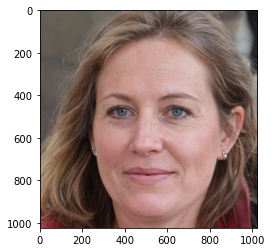

In [32]:
img = gen.get_images(np.reshape(z[0], (1,512)))
plt.imshow(img[0]/255)

Predictions for the image above: 
- Eyeglasses: **2.3424625e-05** 
- Smiling: **9.7760320e-01** 
- Male: **3.3760071e-04**
- No_Beard: **9.9998659e-01**
- Young: **8.0151093e-01**

In [33]:
import pickle
with open('predictions/predictions_xception_5attr.pkl', 'wb') as f:
    pickle.dump(model_predictions, f)

## Next notebook
Continue to 03_regress_feature_axis.